# Abstract
So this part combines DEM and the YOLO model
Note
1. store the yolo model in ur drive somewere
2. To use this ull have to upload the tif images from ur local system - i suggest downloading them from the drive
3. all you need to change is the path of ur yolo model
4. the png for the tif is stored temporarily in collab environment



# Requirements


In [1]:
!pip install rasterio geopandas pystac-client planetary-computer plotly matplotlib scipy ultralytics --upgrade -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3

# Importing everything

In [2]:
from google.colab import files
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import rasterio
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

from pystac_client import Client
import planetary_computer
from rasterio.warp import transform_bounds
from pyproj import CRS
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling
from rasterio.windows import from_bounds
from scipy.ndimage import gaussian_filter, sobel

# YOLO & Colab imports
from google.colab import files
import cv2
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#@title file upload - Upload ur tif file here from ur system



from PIL import Image
uploaded = files.upload()
tif_file = list(uploaded.keys())[0]
png_file = os.path.join("/content", tif_file.replace('.tif', '.png'))
with rasterio.open(tif_file) as src:
    bounds = src.bounds
    crs = src.crs
    width = src.width
    height = src.height
    resolution = src.res[0]  # should be 10.0 for Sentinel
    b2 = src.read(1)  # Blue
    b3 = src.read(2)  # Green
    b4 = src.read(3)  # Red

    rgb = np.stack([b4, b3, b2], axis=-1)  # Rearrange to RGB
    rgb = np.nan_to_num(rgb)

    # Stretch to 0-255 safely
    rgb = (255 * (rgb - rgb.min()) / (rgb.max() - rgb.min())).astype(np.uint8)
    img = Image.fromarray(rgb, mode='RGB')
    img.save(png_file)

    bounds_wgs84 = transform_bounds(src.crs, "EPSG:4326", *bounds)


print(f'🖼️ Saved PNG: {png_file} \n')
print(f"Bounds (meters): {bounds}")
print(f"Bounds (lat/lon): { bounds_wgs84}")
print(f"Resolution: {resolution} m | Size: {width} x {height} \n")




Saving id_160.tif to id_160.tif


/tmp/ipython-input-3893059171.py:21: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(rgb, mode='RGB')


Original bounds: BoundingBox(left=-61.81370352096316, bottom=-0.5371925399034738, right=-61.767889441473066, top=-0.49101913429973043) | CRS: EPSG:4326
Translated to lat/lon: (-61.81370352096316, -0.5371925399034738, -61.767889441473066, -0.49101913429973043)
🖼️ Saved PNG: /content/id_160.png
Bounds: BoundingBox(left=-61.81370352096316, bottom=-0.5371925399034738, right=-61.767889441473066, top=-0.49101913429973043)
Resolution: 8.983152841195215e-05 m | Size: 510 x 514


Using DEM file: id_160.tif


/usr/local/lib/python3.11/dist-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Flat area percentage (<2.0°): 9.07%


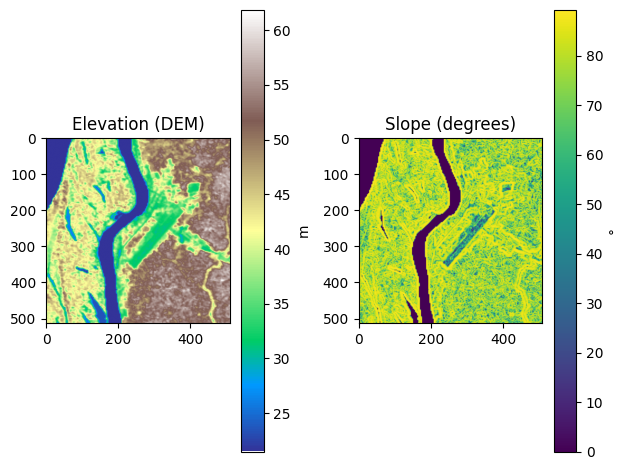

DEM flatness check returned: False


In [6]:
#@title DEM preprocessor


# Terrain Flatness
def is_terrain_flat_enough(tif_file, slope_threshold=2.0, min_flat_pct=10.0): # this part has the setting - atleast 10% of the area should have less than 2 degree slope
    with rasterio.open(tif_file) as src:
        bounds = src.bounds
        crs = src.crs
        width, height = src.width, src.height
        bounds_wgs84 = transform_bounds(src.crs, "EPSG:4326", *bounds)

    stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        collections=["cop-dem-glo-30"],
        bbox=bounds_wgs84,
        max_items=1
    )

    items = list(search.get_items())
    if len(items) == 0:
        raise ValueError("No DEM item found for bounding box")

    item = items[0]
    signed_url = planetary_computer.sign(item.assets["data"].href)

    with rasterio.open(signed_url) as dem_src:
        with WarpedVRT(dem_src, crs=CRS.from_epsg(4326)) as vrt:
            window = from_bounds(*bounds_wgs84, transform=vrt.transform)
            dem = vrt.read(1, window=window, out_shape=(height, width), resampling=Resampling.bilinear)
            dem = dem.astype(float)
            dem[dem == dem_src.nodata] = np.nan

    dx = sobel(dem, axis=1)
    dy = sobel(dem, axis=0)
    slope = np.sqrt(dx**2 + dy**2)
    slope_deg = np.degrees(np.arctan(slope))

    flat_pct = (np.sum(slope_deg < slope_threshold) / slope_deg.size) * 100.0
    print(f"Flat area percentage (<{slope_threshold}°): {flat_pct:.2f}%")


    # plots are for reference cus they look cool

    plt.subplot(1, 2, 1)
    plt.title("Elevation (DEM)")
    plt.imshow(dem, cmap='terrain')
    plt.colorbar(label='m')

    plt.subplot(1, 2, 2)
    plt.title("Slope (degrees)")
    plt.imshow(slope_deg, cmap='viridis')
    plt.colorbar(label='°')

    plt.tight_layout()
    plt.show()

    return flat_pct >= min_flat_pct


# DEM Preprocessor: checks DEM, creates PNG for YOLO, patches files.upload()


from google.colab import files
import rasterio
import numpy as np
from PIL import Image
import io, os

# If you already have a DEM file path, set dem_path to it. Otherwise upload a TIF now.
dem_path = tif_file
if dem_path is None:
    print("Please upload your DEM TIF (~512x512).")
    uploaded = files.upload()
    dem_path = list(uploaded.keys())[0]

print("Using DEM file:", dem_path)

# Run DEM flatness check
try:
    flat_ok = is_terrain_flat_enough(dem_path)
    print(f"DEM flatness check returned: {flat_ok}")
except Exception as e:
    print("Warning: is_terrain_flat_enough raised an exception:", e)
    flat_ok = None




image 1/1 /content/id_160.png: 640x640 2 airstrips, 598.2ms
Speed: 4.0ms preprocess, 598.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


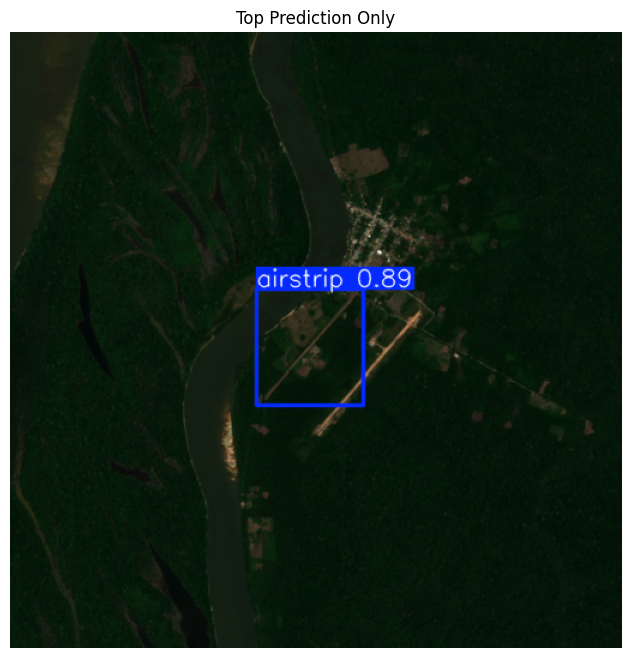

In [10]:
#@title Yolo prediction


model_path = "/content/drive/MyDrive/yolo_models/airstrip_model_20250812_124611/train/weights/best.pt"
model = YOLO(model_path)

results = model(png_file, conf=0.30)

for r in results:
    if len(r.boxes) == 0:
        print("❌ No detections found.")
        continue
    max_idx = r.boxes.conf.argmax()
    r.boxes = r.boxes[max_idx:max_idx+1]
    im_array = r.plot()  # Red box in RG

    im_array_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(im_array_rgb)
    plt.axis('off')
    plt.title("Top Prediction Only")
    plt.show()